In [63]:
import numpy as np
import scipy.stats as stats
import seaborn as sbn
import matplotlib.pyplot as plt
import time
sbn.set()

<h3>(1) Generate sample from geometric distribution </h3>

The geometric distribution is created from a uniformly distributed sample and compared to a geometrically distributed sample using a built-in function in python.

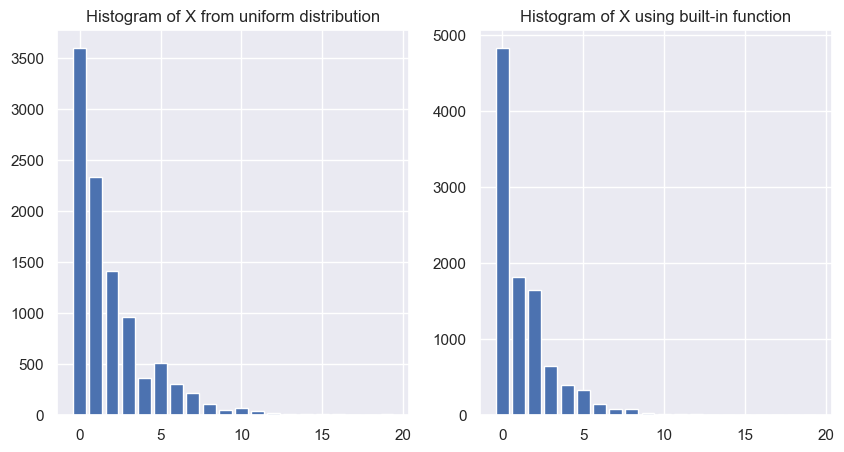

In [31]:
p = .2
n = 10000

U = np.random.uniform(0, 1, size = n)
X_geom = np.floor(np.log(U) / np.log(1 - p)) + 1
X_geom = X_geom.astype(int)

n_bins = 20

X_geom_true = np.random.geometric(p = p, size = n)

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].bar(np.arange(0, n_bins), height = np.histogram(X_geom, bins = n_bins)[0])
ax[0].set_title('Histogram of X from uniform distribution')
ax[1].bar(np.arange(0, n_bins), height = np.histogram(X_geom_true, bins = n_bins)[0])
ax[1].set_title('Histogram of X using built-in function')

plt.show()

The two histograms above are very similar, showing that we have created a geometrically distributed sample from a uniformly distributed sample.

<h3>(2a) Simulate 6-point distribution using crude method </h3>

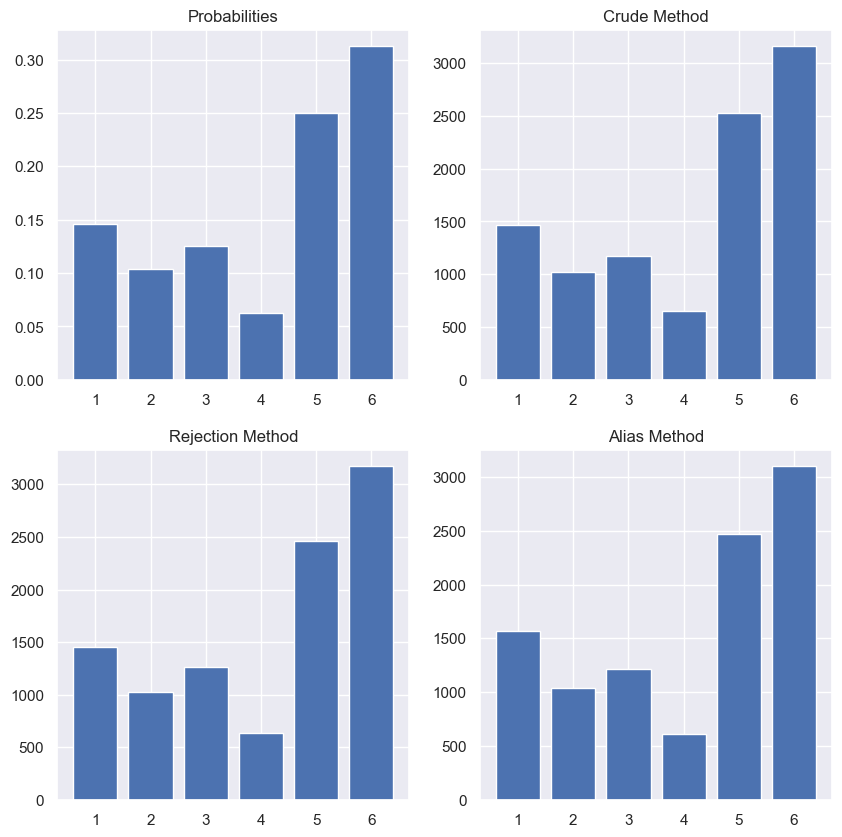

In [45]:
def crude_method(P, n = 10000):
    U = np.random.uniform(0, 1, size = n)
    probs = np.cumsum(P)
    m = len(probs)

    X = np.zeros_like(U)

    for i, u in enumerate(U):
        for j in range(1, m):
            if probs[j - 1] < u and u <= probs[j]:
                X[i] = j

    return X
    

def rejection_method(P, n = 10000):
    X = np.zeros(n)
    k = len(P)
    c = np.max(P)


    for i in range(n):
        found = False

        while (not found):
        
            temp = np.random.uniform(0, 1, size = 2)
            U1 = temp[0]
            U2 = temp[1]

            I = np.floor(k * U1)
            I = I.astype(int)

            if U2 <= P[I] / c:
                X[i] = I
                found = True

    return X


def alias_method(P, n):

    # Setup
    k = len(P)
    L = np.arange(0, k)
    F = k * P
    G = np.argwhere(F >= 1).flatten().tolist()
    S = np.argwhere(F <= 1).flatten().tolist()

    eps = 0.01

    while len(S) != 0:
        i = G[0] 
        j = S[0]

        L[j] = i

        F[i] = F[i] - (1 - F[j])

        if F[i] < 1 - eps:
            G.remove(i)
            S.append(i)

        S.remove(j)


        # Run
        X = np.zeros(n)
        for i in range(n):
            temp = np.random.uniform(0, 1, size = 2)
            U1 = temp[0]
            U2 = temp[1]

            I = int(np.floor(k * U1))
            I = int(I)

            if U2 <= F[I]:
                X[i] = I
            else:
                X[i] = L[I]

    return X


P = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16])

n_bins = len(P)

X1 = crude_method(P, n)
X1_hist = np.histogram(X1, bins = n_bins)[0]

X2 = rejection_method(P, n)
X2_hist = np.histogram(X2, bins = n_bins)[0]

X3 = alias_method(P, n)
X3_hist = np.histogram(X3, bins = n_bins)[0]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].bar(np.arange(1, 7, 1), height=P)
axs[0, 0].set_title('Probabilities')

axs[0, 1].set_title('Crude Method')
axs[0, 1].bar(np.arange(1, 7, 1), height = X1_hist)

axs[1, 0].set_title('Rejection Method')
axs[1, 0].bar(np.arange(1, 7, 1), height=X2_hist)

axs[1, 1].set_title('Alias Method')
axs[1, 1].bar(np.arange(1, 7, 1), height=X3_hist)

plt.show()

The different simulations of the point distributions are shown for 10000 samples. While they are similar there are differences between the histograms.

<h3>(3) and (4) Compare the different discrete random variable simulation methods</h3>

To test the different methods for simulating random variables we use the built in chi square test to see if the histograms of the variables come from a distribution with the given probabilities

In [53]:
E_freq = P * n # Expected frequencies

discrete_rv_sim = {
    'crude' : X1_hist,
    'rejection' : X2_hist,
    'alias' : X3_hist    
}

for k, v in discrete_rv_sim.items():
    test = stats.chisquare(f_obs = v, f_exp = E_freq)
    Z = test.statistic
    p = test.pvalue

    print(f'Simulation method {k} => (test statistic, pvalue) = {(Z, p)}')



Simulation method crude => (test statistic, pvalue) = (6.456125714285716, 0.2643296110222158)
Simulation method rejection => (test statistic, pvalue) = (1.7172914285714325, 0.8867141729465251)
Simulation method alias => (test statistic, pvalue) = (10.234125714285693, 0.06886677068115828)


Using a threshold $\alpha > 0.05$ we accept the null-hypothesis that these simulated discrete random variables comes from a distribution with the specifed probabilites. The alias method is seemingly the closest to being rejected with a test-statistic that is more extreme than the others. conversely, the rejection method seems to be performing the best. Next is testing the time it takes to simulate discrete random variables with the different methods.

In [81]:
methods = {'crude' : crude_method, 'rejection' : rejection_method, 'alias' : alias_method}
n_generate = 1000000

for k, method in methods.items():
    start = time.time()    
    X = method(P, n = n_generate)
    stop = time.time()
    t = stop - start 
    print(f'Spent t = {t} seconds simulating {n_generate} random variables using {k} method')


Spent t = 1.0803461074829102 seconds simulating 1000000 random variables using crude method
Spent t = 4.63048791885376 seconds simulating 1000000 random variables using rejection method
Spent t = 11.200064182281494 seconds simulating 1000000 random variables using alias method


We see that the alias method is the slowest, while the crude method is the fastest. All in all the rejection method is the preferred method if wanting to go for accuracy while the crude method is best if speed is preferred